In [1]:
datasetName = 'brain_LGN_AllenBrainAtlas'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/brain_LGN_AllenBrainAtlas")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,cell_ID,F1S4_161018_001_A01,F1S4_161018_001_B01,F1S4_161018_001_C01,F1S4_161018_001_E01
,<chr>,<int>,<int>,<int>,<int>
1,3.8-1.2,0,0,0,0
2,3.8-1.3,0,0,0,0
3,3.8-1.4,0,0,0,0
4,3.8-1.5,0,0,0,0
5,5-HT3C2,2,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
F1S4_161018_001_A01,brain,LGN,MC-p,normal,H200.1030,M,19710
F1S4_161018_001_B01,brain,LGN,MC-p,normal,H200.1030,M,19710
F1S4_161018_001_C01,brain,LGN,MC-p,normal,H200.1030,M,19710
F1S4_161018_001_E01,brain,LGN,MC-p,normal,H200.1030,M,19710
F1S4_161018_001_F01,brain,LGN,MC-p,normal,H200.1030,M,19710


[1] LGN Exc BTNL9 LGN Exc BTNL9 LGN Inh NTRK1 LGN Exc BTNL9 LGN Exc BTNL9
13 Levels: Astro CPAMD8 Astro LGR6 LGN Exc BTNL9 ... OPC PDGFRA

In [4]:
genes <- data.matrix[, 1]
genes[duplicated(genes)]
# 2-Mar: 30913, 30917
# 1-Mar: 30912, 30914

[1] "1-Mar" "2-Mar"

In [5]:
data.matrix <- data.matrix[c(-30912, -30913, -30914, -30917), ]
row.names(data.matrix) = data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]

,F1S4_161018_001_A01,F1S4_161018_001_B01,F1S4_161018_001_C01,F1S4_161018_001_E01,F1S4_161018_001_F01
,<int>,<int>,<int>,<int>,<int>
3.8-1.2,0,0,0,0,0
3.8-1.3,0,0,0,0,0
3.8-1.4,0,0,0,0,0
3.8-1.5,0,0,0,0,0
5-HT3C2,2,0,0,0,0


In [6]:
# Pre-processing
min.cells = 3
min.features = 200
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 5
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

In [7]:
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = '^MT-')
# dataobj <- subset(dataobj, subset = nFeature_RNA > 200)
# dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [8]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 4000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [9]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  PLP1, ST18, MOBP, MBP, SLC5A11, SLC44A1, TMEM144, CTNNA3, LOC101927967, TF 
	   CDK18, RAPGEF5, CARNS1, MOG, GPM6B, DPYD, PLEKHH1, TMEM63A, UGT8, CNDP1 
	   PIEZO2, COL4A5, ANLN, CLDN11, HAPLN2, C10orf90, CERCAM, FOLH1, ENPP2, SHROOM4 
Negative:  DPP10, FGF13, FAM19A2, LOC105377862, LOC101928570, KCNC2, PRKG1, RYR2, PCP4, FAT3 
	   TRPC3, NEFM, NEFL, MEF2C, GPM6A, C10orf11, DGKB, HCN1, DCLK1, MMP16 
	   GALNTL6, SIPA1L2, NEBL, SAMD5, PLXDC2, KHDRBS2, RGS16, MDH1, SCG2, COX1 
PC_ 2 
Positive:  TRPM3, ATP1A2, MAPK4, RNF219-AS1, HIF3A, C1orf61, TNC, GFAP, PRODH, AQP4 
	   PTPRZ1, SORBS1, PRKCA, PLCB1, PRRX1, LINC00299, FGFR3, RFX2, NKAIN3, ADRA1A 
	   ALK, LUZP2, CHL1, SLC1A2, ATP13A4, ATP1B2, LOC101929418, LINC01088, RANBP3L, GPM6A 
Negative:  NEFM, RNF220, NEFL, EDIL3, LOC101928570, PCP4, ANKRD18A, LOC105377862, LPAR1, PLD1 
	   SPOCK3, NKAIN2, ELMO1, LRRC63, SYNJ2, MAN2A1, RGS16, FGF13, CNTN2, DPYSL5 
	   ENPP2, GRM3, FGFR2, LOC105371308, SPP1, LOC105369474, FAM95C, M

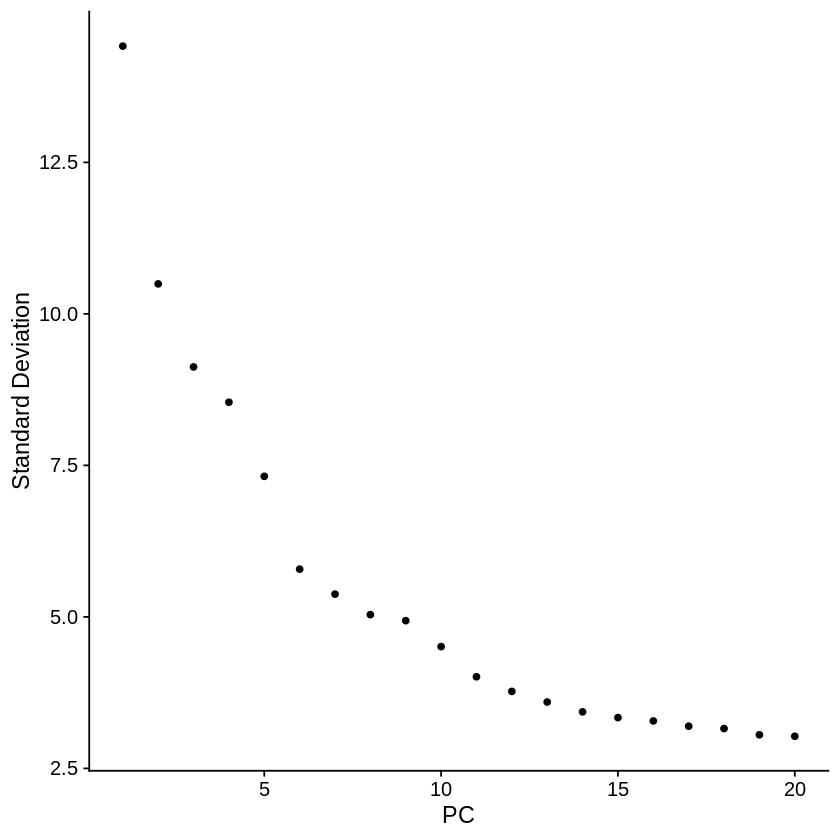

In [10]:
ElbowPlot(dataobj) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [11]:
dev.off()
pcDim = 10 # set as 75 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
07:26:58 UMAP embedding parameters a = 0.9922 b = 1.112

07:26:58 Read 1576 rows and found 10 numeric columns

07:26:58 Using Annoy for neighbor search, n_neighbors = 30

07:26:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

07:26:59 Writing NN index file to temp file /tmp/Rtmpiwobxa/file27804d04461e

07:26:59 Searching Annoy index using 1 thread, search_k = 3000

07:26:59 Annoy recall = 100%

07:27:00 Commencing smooth kNN distance calibration using 1 thread

07:27:00 Initializing fr

In [12]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6, n.start = 10)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1576
Number of edges: 47177

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8732
Number of communities: 13
Elapsed time: 0 seconds


07:27:07 UMAP embedding parameters a = 0.9922 b = 1.112

07:27:07 Read 1576 rows and found 10 numeric columns

07:27:07 Using Annoy for neighbor search, n_neighbors = 30

07:27:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

07:27:07 Writing NN index file to temp file /tmp/Rtmpiwobxa/file278064827e63

07:27:07 Searching Annoy index using 1 thread, search_k = 3000

07:27:07 Annoy recall = 100%

07:27:08 Commencing smooth kNN distance calibration using 1 thread

07:27:08 Initializing from normalized Laplacian + noise

07:27:08 Commencing optimization for 500 epochs, with 59522 positive edges

07:27:12 Optimization finished



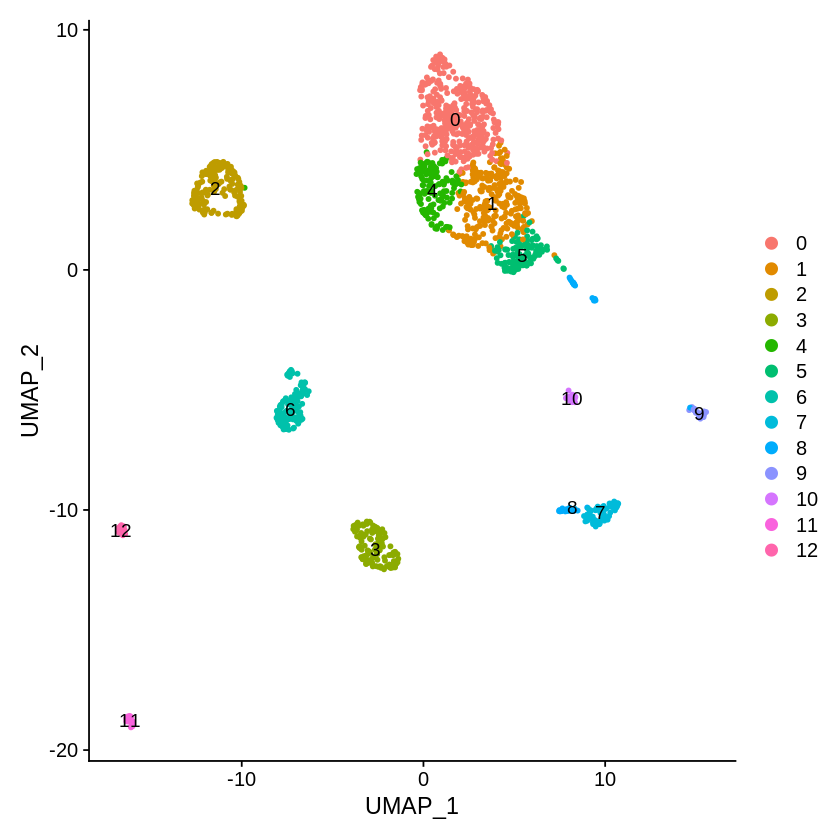

In [13]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [141]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

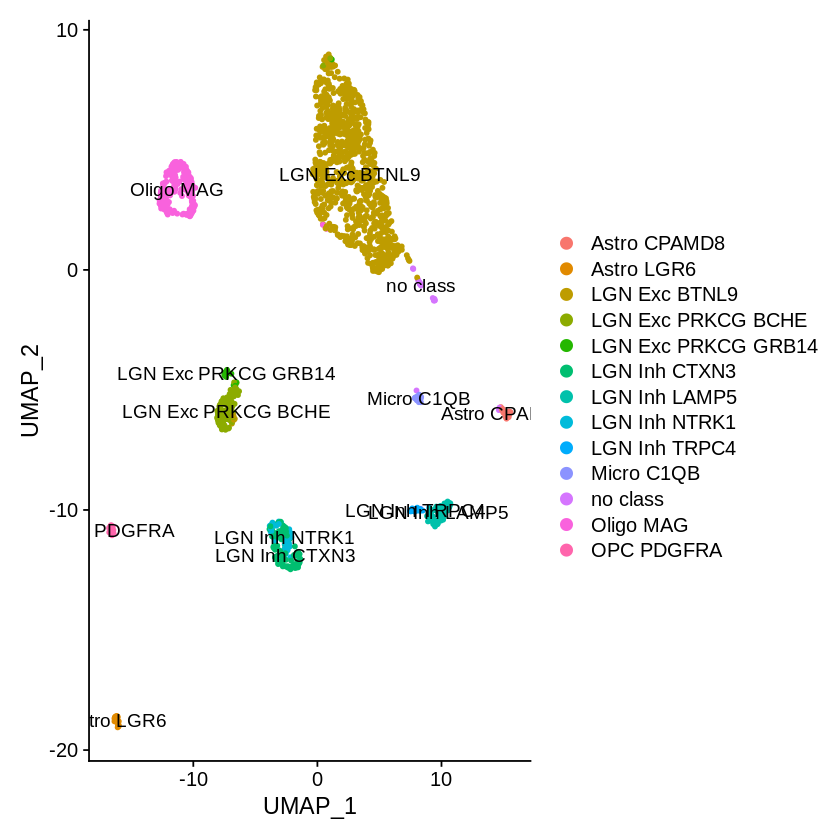

In [14]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
p_umap2

In [16]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [17]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



In [15]:
new.cluster.ids <- c('Brain-Nerve tissue-Excitatory neuron-BTNL9', 'Brain-Nerve tissue-Excitatory neuron-BTNL9', 'Brain-Nerve tissue-Oligodendrocyte-MTG',
                    'Brain-Nerve tissue-Inhibitory neuron-CTXN3', 'Brain-Nerve tissue-Excitatory neuron-SLC17A6', 'Brain-Nerve tissue-Excitatory neuron-BTNL9',
                    'Brain-Nerve tissue-Excitatory neuron-PRKCG','Brain-Nerve tissue-Inhibitory neuron-LAMP5', 'Brain-Nerve tissue-Inhibitory neuron-TRPC4',
                    'Brain-Nerve tissue-Astrocyte-CPAMD8', 'Brain-Nerve tissue-Microglia-C1QB', 'Brain-Nerve tissue-Astrocyte-LGR6', 
                    'Brain-Nerve tissue-Oligodendrocyte precursor cell-OLIG2')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

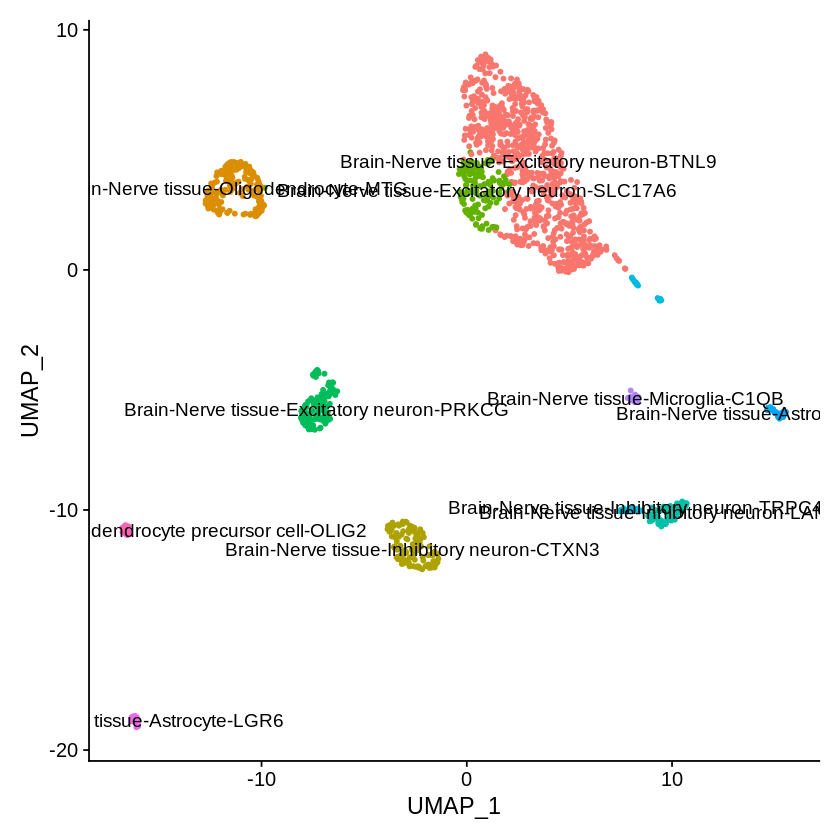

In [16]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [17]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [ ]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [150]:
annotation <- as.data.frame(cbind(colnames(data.matrix), data.annotation, seurat_cluster = as.character(Idents(dataobj))))
annotation <- annotation[, -1]
annotation <- annotation[order(annotation$seurat_cluster), ]
print(annotation)

                           cell_cluster seurat_cluster
F1S4_161018_001_E01       LGN Exc BTNL9              0
F1S4_161018_002_F01       LGN Exc BTNL9              0
F1S4_161018_002_G01       LGN Exc BTNL9              0
F1S4_161018_003_D01       LGN Exc BTNL9              0
F1S4_161018_003_E01       LGN Exc BTNL9              0
F1S4_161018_006_A01       LGN Exc BTNL9              0
F1S4_161018_007_D01       LGN Exc BTNL9              0
F1S4_161018_007_E01       LGN Exc BTNL9              0
F1S4_161018_008_E01       LGN Exc BTNL9              0
F1S4_161018_008_G01       LGN Exc BTNL9              0
F1S4_161018_009_A01       LGN Exc BTNL9              0
F1S4_161018_011_B01       LGN Exc BTNL9              0
F1S4_161018_011_D01       LGN Exc BTNL9              0
F1S4_161018_012_A01       LGN Exc BTNL9              0
F1S4_161018_012_G01       LGN Exc BTNL9              0
F1S4_161018_013_E01       LGN Exc BTNL9              0
F1S4_161018_014_F01       LGN Exc BTNL9              0
F1S4_16101

In [161]:
write.csv(annotation, file = "/stor/public/hcad/brain_LGN_AllenBrainAtlas/brain_LGN_AllenBrainAtlas.seurat.correctness.csv", quote = FALSE)

In [156]:
new.cluster.ids <- c("LGN Exc BTNL9", "LGN Exc BTNL9", "Oligo MAG", "LGN Inh NTRK1/LGN Inh CTXN3", "LGN Exc BTNL9", "LGN Exc BTNL9", 
                     "LGN Exc PRKCG BCHE/LGN Exc PRKCG GRB14", "LGN Inh LAMP5", "LGN Inh TRPC4/no class", "Astro CPAMD8", "Micro C1QB", "Astro LGR6", 'OPC PDGFRA')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

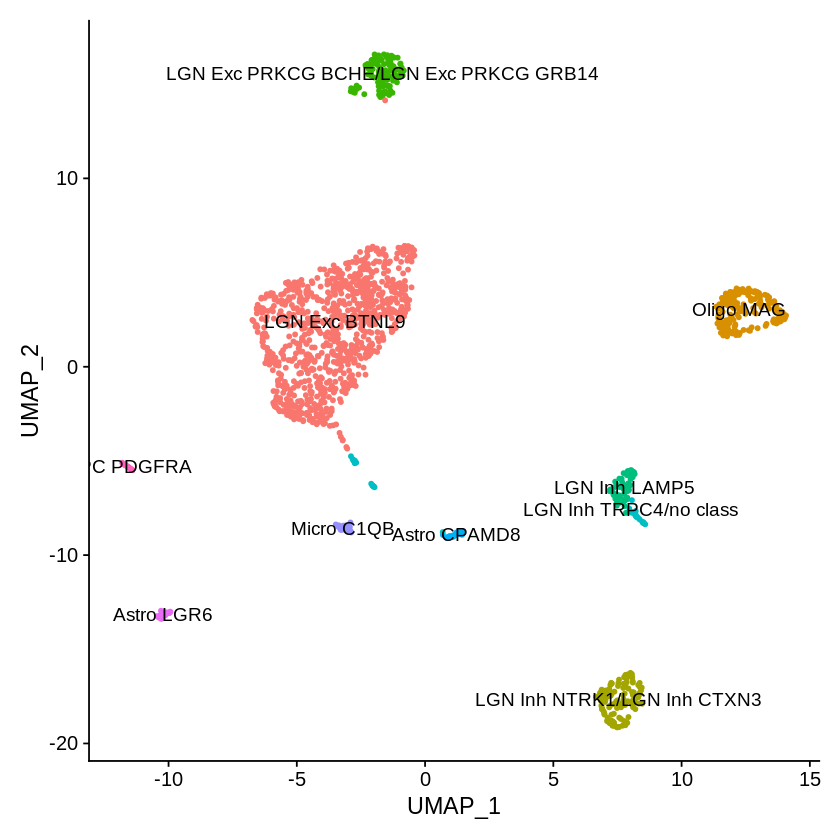

In [158]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [159]:
ggsave(paste0(datasetName,".seurat.umap2.tiff"), plot = p_umap2, width = 8, height = 5)

In [144]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)


Calculating cluster LGN Exc BTNL9

Calculating cluster Oligo MAG

Calculating cluster LGN Inh NTRK1/LGN Inh CTXN3

Calculating cluster LGN Exc PRKCG BCHE/LGN Exc PRKCG GRB14

Calculating cluster LGN Inh LAMP5

Calculating cluster LGN Inh TRPC4/no class

Calculating cluster Astro CPAMD8

Calculating cluster Micro C1QB

Calculating cluster Astro LGR6

Calculating cluster OPC PDGFRA



In [160]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [2]:
datasetName = 'brain_LGN_AllenBrainAtlas'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_LGN_AllenBrainAtlas")
marker <- read.delim(file = paste0(datasetName,".seurat.markers.txt"))

In [7]:
marker[order(marker$cluster),]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
4930,2.790308e-126,0.8563541,0.552,0.005,1.161577e-121,Astro CPAMD8,APLNR
4931,6.048009e-97,1.0488579,0.793,0.027,2.517726e-92,Astro CPAMD8,AEBP1
4932,2.250197e-89,0.9885363,0.483,0.008,9.367346e-85,Astro CPAMD8,LOC105378850
4933,8.665388e-86,1.1493930,0.483,0.008,3.607315e-81,Astro CPAMD8,ID3
4934,3.207829e-59,0.8456177,0.345,0.006,1.335387e-54,Astro CPAMD8,ID1
4935,6.723970e-57,2.5371575,0.931,0.090,2.799121e-52,Astro CPAMD8,AQP4
4936,1.445021e-56,1.1191368,0.517,0.021,6.015479e-52,Astro CPAMD8,LOC105376628
4937,1.096805e-52,0.9135645,0.483,0.019,4.565888e-48,Astro CPAMD8,LINC01354
4938,8.552607e-52,0.5544446,0.552,0.027,3.560365e-47,Astro CPAMD8,LPAR4


In [6]:
levels(marker$cluster)

[1] "Astro CPAMD8"                          
 [2] "Astro LGR6"                            
 [3] "LGN Exc BTNL9"                         
 [4] "LGN Exc PRKCG BCHE/LGN Exc PRKCG GRB14"
 [5] "LGN Inh LAMP5"                         
 [6] "LGN Inh NTRK1/LGN Inh CTXN3"           
 [7] "LGN Inh TRPC4/no class"                
 [8] "Micro C1QB"                            
 [9] "Oligo MAG"                             
[10] "OPC PDGFRA"